# Mario Escalante

In [ ]:
# FOOD-101 + NUTRITION + RESNET18 (A100-OPTIMIZED, UNIT-EFFICIENT)
# 0) Mount Google Drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 1) Imports

import os, time, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
# 2) Device + GPU identification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

gpu_name = None
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print("GPU:", gpu_name)
else:
    print("⚠️ No GPU. Runtime -> Change runtime type -> GPU")

# If you didn't get H100, we warn (we can’t programmatically switch GPU types; Colab controls that)
if gpu_name is not None and ("H100" not in gpu_name):
    print("\n⚠️ NOTE: You are not on H100 right now.")
    print("   If compute units are low, consider selecting a cheaper GPU (e.g., L4) in Colab Runtime settings.")
    print("   But the biggest unit saver is training from /content (local disk), not from Drive.")


Device: cuda
GPU: NVIDIA A100-SXM4-80GB

⚠️ NOTE: You are not on H100 right now.
   If compute units are low, consider selecting a cheaper GPU (e.g., L4) in Colab Runtime settings.
   But the biggest unit saver is training from /content (local disk), not from Drive.


In [ ]:
# 1) Device + speed settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# TF32 (new API) + cuDNN benchmark
try:
    torch.backends.cuda.matmul.fp32_precision = "tf32"
    torch.backends.cudnn.conv.fp32_precision = "tf32"
except Exception:
    pass
torch.backends.cudnn.benchmark = True

# Reduce fragmentation risk (safe)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

Device: cuda
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
 #4) Load Nutrition CSV + calories mapping
# ----------------------------
csv_path = "/content/drive/MyDrive/DS_FINAL_PROJECT/nutrition.csv"
df = pd.read_csv(csv_path)

df["weight"]   = pd.to_numeric(df["weight"], errors="coerce")
df["calories"] = pd.to_numeric(df["calories"], errors="coerce")
df = df.dropna(subset=["label", "weight", "calories"])

df["cal_per_100g"] = (df["calories"] / df["weight"]) * 100
cal_per_100g_map = df.groupby("label")["cal_per_100g"].median().to_dict()

print("Nutrition labels:", len(cal_per_100g_map))
print("Example:", list(cal_per_100g_map.items())[:5])

Nutrition labels: 101
Example: [('Cupcakes', 400.0), ('Fish and Chips', 250.0), ('Grilled Cheese', 266.66666666666663), ('Hot and Sour Soup', 75.0), ('Lobster Roll', 200.0)]


In [ ]:
# 5) UNIT-SAVING DATA STRATEGY: TAR CACHE ON DRIVE → EXTRACT TO /content                     SKIP  BUT KEEP TO EXPLAIN
# ============================================================
# Why:
# - Reading 100k JPGs directly from Drive is extremely slow -> burns compute units.
# - Copying folders with rsync can also be slow.
# - Best compromise: keep a TAR archive on Drive and extract to /content each session.
#
# You do this once:
#   create TAR on Drive
# Then each session:
#   extract TAR to /content (fast)
# Train from /content (fast)
# ============================================================

drive_image_root = "/content/drive/MyDrive/DS_FINAL_PROJECT/food-101/images"
tar_path = "/content/drive/MyDrive/DS_FINAL_PROJECT/food101_images.tar"
local_image_root = "/content/food101_images"  # extracted dataset location

if not os.path.isdir(drive_image_root):
    raise FileNotFoundError(f"Drive image folder not found: {drive_image_root}")

# 5.1 Create TAR if missing (one-time cost)
if not os.path.exists(tar_path):
    print("\nCreating TAR archive on Drive (one-time). This may take time, but saves huge units later...")
    # Create tar of the images folder content (class folders)
    # Result tar will contain: apple_pie/, baby_back_ribs/, ...
    !tar -cf "{tar_path}" -C "{drive_image_root}" .
    print("✅ TAR created:", tar_path)
else:
    print("\n✅ TAR cache exists:", tar_path)

# 5.2 Extract TAR to /content if needed (per session)
if (not os.path.isdir(local_image_root)) or (len(os.listdir(local_image_root)) == 0):
    print("\nExtracting TAR to /content (fast) ...")
    os.makedirs(local_image_root, exist_ok=True)
    # Extract into local_image_root
    !tar -xf "{tar_path}" -C "{local_image_root}"
    print("✅ Extract complete:", local_image_root)
else:
    print("\n✅ Local dataset already present in /content. Skipping extraction.")


In [ ]:
%%bash
# SKIP BUT EXPLAIN
TAR_PATH="/content/drive/MyDrive/DS_FINAL_PROJECT/food101_images.tar"
LOCAL_DIR="/content/food101_images"

# Clean old extraction (optional)
rm -rf "$LOCAL_DIR"
mkdir -p "$LOCAL_DIR"

echo "Extracting TAR to /content..."
tar -xf "$TAR_PATH" -C "$LOCAL_DIR"
echo "✅ Extracted to $LOCAL_DIR"

# Quick sanity check
ls "$LOCAL_DIR" | head


Extracting TAR to /content...
✅ Extracted to /content/food101_images
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [ ]:
# IMPORTANT:                     USE THIS
# After extraction, local_image_root contains class folders directly:
# /content/food101_images/apple_pie/*.jpg, ...

# ============================================================
# 6) Drop empty class folders
# ============================================================

local_image_root = "/content/food101_images"


valid_classes = []
empty_classes = []

for cls in sorted(os.listdir(local_image_root)):
    cls_path = os.path.join(local_image_root, cls)
    if cls.startswith(".") or (not os.path.isdir(cls_path)):
        continue

    has_img = any(f.lower().endswith(IMG_EXTENSIONS) for f in os.listdir(cls_path))
    if has_img:
        valid_classes.append(cls)
    else:
        empty_classes.append(cls)

print("\nClasses with images:", len(valid_classes))
print("Empty classes:", len(empty_classes))
if empty_classes:
    print("Example empty:", empty_classes[:10])


Classes with images: 101
Empty classes: 0


In [ ]:
# 7) Dataset filtering (keep only valid classes)             USE THIS
# ============================================================
# We use ImageFolder to read file paths efficiently.
base_folder = datasets.ImageFolder(root=local_image_root, transform=None)
orig_idx_to_class = {v: k for k, v in base_folder.class_to_idx.items()}
valid_set = set(valid_classes)

filtered_samples = [
    (path, orig_idx)
    for (path, orig_idx) in base_folder.samples
    if orig_idx_to_class[orig_idx] in valid_set
]

filtered_classes = sorted(list(valid_set))
class_to_idx = {cls: i for i, cls in enumerate(filtered_classes)}
num_classes = len(filtered_classes)

print("\nFiltered classes:", num_classes, "(ideally 101 if complete)")
print("Filtered images:", len(filtered_samples))

# If your teacher requires exactly 101 and you truly have complete dataset:
# assert num_classes == 101, f"Expected 101 classes, got {num_classes}"


Filtered classes: 101 (ideally 101 if complete)
Filtered images: 100770


In [ ]:
# 4) TRANSFORMS (IMG_SIZE=192 baseline)                                           USE THIS
# ============================================================
IMG_SIZE = 192

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE / 0.875)),  # ~219 for 192
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

In [ ]:
# ============================================================                       USE THIS
# 5) DATASET CLASS + TRAIN/VAL SPLIT (reproducible)
# ============================================================
class Food101Filtered(Dataset):
    def __init__(self, samples, orig_idx_to_class, class_to_idx, loader, transform=None):
        self.samples = samples
        self.orig_idx_to_class = orig_idx_to_class
        self.class_to_idx = class_to_idx
        self.classes = list(class_to_idx.keys())
        self.loader = loader
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, orig_idx = self.samples[i]
        cls_name = self.orig_idx_to_class[orig_idx]
        y = self.class_to_idx[cls_name]
        img = self.loader(path)
        if self.transform:
            img = self.transform(img)
        return img, y

# IMPORTANT: define loader from ImageFolder
loader = base_folder.loader

# Split 90/10
n_total = len(filtered_samples)
n_train = int(0.9 * n_total)

g = torch.Generator().manual_seed(42)
perm = torch.randperm(n_total, generator=g).tolist()

train_samples = [filtered_samples[i] for i in perm[:n_train]]
val_samples   = [filtered_samples[i] for i in perm[n_train:]]

train_dataset = Food101Filtered(train_samples, orig_idx_to_class, class_to_idx, loader, transform=train_transform)
val_dataset   = Food101Filtered(val_samples,   orig_idx_to_class, class_to_idx, loader, transform=val_transform)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))

Train size: 90693
Val size: 10077


In [ ]:
# ============================================================                  USE THIS
# 6) DATALOADERS (local disk -> workers help)
# ============================================================
batch_size = 128
num_workers = 4 if torch.cuda.is_available() else 0
pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin,
    persistent_workers=(num_workers > 0),
    prefetch_factor=2 if num_workers > 0 else None,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin,
    persistent_workers=(num_workers > 0),
    prefetch_factor=2 if num_workers > 0 else None
)

print(f"DataLoader: batch_size={batch_size}, num_workers={num_workers}, IMG_SIZE={IMG_SIZE}")


DataLoader: batch_size=128, num_workers=4, IMG_SIZE=192


In [ ]:
# ============================================================                      USE THIS
# 7) MODEL (ResNet-18) + HEAD (512 -> 256 -> num_classes)
# ============================================================
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

model = model.to(device).to(memory_format=torch.channels_last)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]


In [ ]:
# ============================================================            USE THIS
# 8) FINETUNE: train layer2 + layer3 + layer4 + fc
# ============================================================
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.layer3.parameters():
    p.requires_grad = True
for p in model.layer2.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params: 11176293


In [ ]:
# ============================================================        USE THIS
# 9) LOSS + OPTIMIZER (layer-wise LR) + SCHEDULER
# ============================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW([
    {"params": model.fc.parameters(),     "lr": 3e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.layer3.parameters(), "lr": 5e-5},
    {"params": model.layer2.parameters(), "lr": 2e-5},
], weight_decay=1e-4)

# Cosine schedule
max_epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)


In [ ]:
# ============================================================
# 10) MIXUP HELPERS (train only)
# ============================================================
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    idx = torch.randperm(x.size(0), device=x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, y, y[idx], lam

def mixup_loss(criterion, logits, y_a, y_b, lam):
    return lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)


In [ ]:
from torch import amp

use_cuda = torch.cuda.is_available()
use_bf16 = use_cuda and torch.cuda.is_bf16_supported()

scaler = amp.GradScaler(
    "cuda",
    enabled=(use_cuda and not use_bf16)
)


In [ ]:
# ============================================================
# 11) AMP (BF16 preferred) + epoch function (with grad clipping + MixUp)
# ============================================================
use_cuda = torch.cuda.is_available()
use_bf16 = use_cuda and torch.cuda.is_bf16_supported()
scaler = amp.GradScaler("cuda", enabled=(use_cuda and (not use_bf16)))

def run_epoch_amp(model, loader, train=True, clip_grad=1.0, mixup_alpha=0.2):
    model.train(train)
    total_loss, total_correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, desc=("Train" if train else "Val"), leave=False):
        x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        # MixUp only in training
        if train and mixup_alpha and mixup_alpha > 0:
            x, y_a, y_b, lam = mixup_data(x, y, alpha=mixup_alpha)

        cast_dtype = torch.bfloat16 if use_bf16 else torch.float16

        with torch.set_grad_enabled(train):
            with amp.autocast("cuda", enabled=use_cuda, dtype=cast_dtype):
                logits = model(x)
                if train and mixup_alpha and mixup_alpha > 0:
                    loss = mixup_loss(criterion, logits, y_a, y_b, lam)
                else:
                    loss = criterion(logits, y)

            if train:
                if use_bf16:
                    loss.backward()
                    if clip_grad is not None:
                        torch.nn.utils.clip_grad_norm_(
                            [p for p in model.parameters() if p.requires_grad],
                            max_norm=clip_grad
                        )
                    optimizer.step()
                else:
                    scaler.scale(loss).backward()
                    if clip_grad is not None:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(
                            [p for p in model.parameters() if p.requires_grad],
                            max_norm=clip_grad
                        )
                    scaler.step(optimizer)
                    scaler.update()

        total_loss += loss.item() * x.size(0)
        # Accuracy with MixUp is approximate
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total


In [ ]:

# 12) CHECKPOINTING TRAIN LOOP (latest + best + resume + early stop)

best_path   = "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt"
latest_path = "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_latest_mixup_192_5th_run.pt"

epochs    = max_epochs
patience  = 3
min_delta = 1e-4

start_epoch = 1
best_val_acc = 0.0
epochs_no_improve = 0

def safe_torch_save(obj, path):
    tmp = path + ".tmp"
    torch.save(obj, tmp)
    os.replace(tmp, path)

# Resume if exists (only safe if architecture + optimizer param groups unchanged)
if os.path.exists(latest_path):
    ckpt = torch.load(latest_path, map_location=device)
    model.load_state_dict(ckpt["model_state"], strict=True)
    if ckpt.get("optimizer_state") is not None:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if ckpt.get("scheduler_state") is not None and scheduler is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    best_val_acc = ckpt.get("best_val_acc", 0.0)
    start_epoch = ckpt.get("epoch", 0) + 1
    print(f"\n✅ Resumed at epoch {start_epoch-1}, best_val_acc={best_val_acc:.4f}")
else:
    print("\nNo latest checkpoint found. Starting fresh training...")

for epoch in range(start_epoch, epochs + 1):
    t0 = time.time()

    train_loss, train_acc = run_epoch_amp(model, train_loader, train=True,  clip_grad=1.0, mixup_alpha=0.2)
    val_loss,   val_acc   = run_epoch_amp(model, val_loader,   train=False, clip_grad=None, mixup_alpha=0.0)

    if scheduler is not None:
        scheduler.step()

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    print(f"Epoch {epoch}/{epochs} | "
          f"train acc={train_acc:.4f} loss={train_loss:.4f} | "
          f"val acc={val_acc:.4f} loss={val_loss:.4f} | "
          f"time={(time.time()-t0)/60:.1f} min")

    latest_ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_val_acc": best_val_acc,
        "img_size": IMG_SIZE,
        "batch_size": batch_size,
        "num_classes": num_classes,
        "classes": filtered_classes,
    }
    safe_torch_save(latest_ckpt, latest_path)

    if val_acc > (best_val_acc + min_delta):
        best_val_acc = val_acc
        epochs_no_improve = 0

        best_ckpt = dict(latest_ckpt)
        best_ckpt["best_val_acc"] = best_val_acc
        safe_torch_save(best_ckpt, best_path)
        print(f"✅ New best saved: best_val_acc={best_val_acc:.4f} -> {best_path}")
    else:
        epochs_no_improve += 1
        print(f"⏳ No improvement {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print("🛑 Early stopping (val acc plateau).")
            break

print("\nFinal best validation accuracy:", best_val_acc)


No latest checkpoint found. Starting fresh training...


Epoch 1/20 | train acc=0.1860 loss=3.2479 | val acc=0.6154 loss=2.1573 | time=3.6 min
✅ New best saved: best_val_acc=0.6154 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 2/20 | train acc=0.2841 loss=2.6250 | val acc=0.6707 loss=1.9362 | time=3.6 min
✅ New best saved: best_val_acc=0.6707 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 3/20 | train acc=0.3208 loss=2.4711 | val acc=0.7046 loss=1.8169 | time=3.6 min
✅ New best saved: best_val_acc=0.7046 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 4/20 | train acc=0.3348 loss=2.3849 | val acc=0.7105 loss=1.7967 | time=3.6 min
✅ New best saved: best_val_acc=0.7105 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 5/20 | train acc=0.3327 loss=2.2908 | val acc=0.7220 loss=1.7240 | time=3.6 min
✅ New best saved: best_val_acc=0.7220 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 6/20 | train acc=0.3732 loss=2.1744 | val acc=0.7334 loss=1.7105 | time=3.6 min
✅ New best saved: best_val_acc=0.7334 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 7/20 | train acc=0.3917 loss=2.1655 | val acc=0.7436 loss=1.6745 | time=3.6 min
✅ New best saved: best_val_acc=0.7436 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 8/20 | train acc=0.3530 loss=2.1108 | val acc=0.7461 loss=1.6603 | time=3.6 min
✅ New best saved: best_val_acc=0.7461 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 9/20 | train acc=0.3665 loss=2.0801 | val acc=0.7543 loss=1.6360 | time=3.6 min
✅ New best saved: best_val_acc=0.7543 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 10/20 | train acc=0.3689 loss=2.0281 | val acc=0.7536 loss=1.6250 | time=3.6 min
⏳ No improvement 1/3


Epoch 11/20 | train acc=0.3983 loss=2.0003 | val acc=0.7583 loss=1.6181 | time=3.5 min
✅ New best saved: best_val_acc=0.7583 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 12/20 | train acc=0.3911 loss=1.9983 | val acc=0.7593 loss=1.6118 | time=3.6 min
✅ New best saved: best_val_acc=0.7593 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 13/20 | train acc=0.4005 loss=1.9554 | val acc=0.7624 loss=1.5915 | time=3.6 min
✅ New best saved: best_val_acc=0.7624 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 14/20 | train acc=0.4251 loss=1.9472 | val acc=0.7660 loss=1.5815 | time=3.6 min
✅ New best saved: best_val_acc=0.7660 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 15/20 | train acc=0.4213 loss=1.8716 | val acc=0.7670 loss=1.5753 | time=3.6 min
✅ New best saved: best_val_acc=0.7670 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 16/20 | train acc=0.4136 loss=1.9207 | val acc=0.7696 loss=1.5794 | time=3.6 min
✅ New best saved: best_val_acc=0.7696 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 17/20 | train acc=0.4361 loss=1.8752 | val acc=0.7711 loss=1.5774 | time=3.6 min
✅ New best saved: best_val_acc=0.7711 -> /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt


Epoch 18/20 | train acc=0.4439 loss=1.8434 | val acc=0.7691 loss=1.5958 | time=3.6 min
⏳ No improvement 1/3


Epoch 19/20 | train acc=0.4102 loss=1.8631 | val acc=0.7711 loss=1.5835 | time=3.6 min
⏳ No improvement 2/3


Epoch 20/20 | train acc=0.4314 loss=1.9159 | val acc=0.7698 loss=1.5863 | time=3.5 min
⏳ No improvement 3/3
🛑 Early stopping (val acc plateau).

Final best validation accuracy: 0.7710628163143792


In [ ]:
epochs_224 = []
train_acc_224 = []
val_acc_224 = []
best_path   = "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_A100_best_mixup_192_5th_run.pt"

In [ ]:
 # 13) OPTIONAL FINAL PHASE: Fine-tune at 224



# Load best weights from 192 phase
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model_state"], strict=True)

# Update transforms to 224
IMG_SIZE = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

train_dataset.transform = train_transform
val_dataset.transform = val_transform

# Adjust loaders if needed
batch_size = 96  # reduce if OOM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=pin)

# Slightly lower LRs for final polish
optimizer = optim.AdamW([
    {"params": model.fc.parameters(),     "lr": 2e-4},
    {"params": model.layer4.parameters(), "lr": 8e-5},
    {"params": model.layer3.parameters(), "lr": 4e-5},
    {"params": model.layer2.parameters(), "lr": 2e-5},
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6, eta_min=1e-6)

# Short run
#for ep in range(1, 7):
   # tr_loss, tr_acc = run_epoch_amp(model, train_loader, train=True, mixup_alpha=0.2)
 #   va_loss, va_acc = run_epoch_amp(model, val_loader, train=False, mixup_alpha=0.0)
  #  scheduler.step()
 #   print(f"[224] Epoch {ep}/6 | train acc={tr_acc:.4f} | val acc={va_acc:.4f}")

for ep in range(1, 7):
    tr_loss, tr_acc = run_epoch_amp(
        model, train_loader, train=True, mixup_alpha=0.2
    )
    va_loss, va_acc = run_epoch_amp(
        model, val_loader, train=False, mixup_alpha=0.0
    )

    scheduler.step()

    epochs_224.append(ep)
    train_acc_224.append(tr_acc)
    val_acc_224.append(va_acc)

    print(f"[224] Epoch {ep}/6 | train acc={tr_acc:.4f} | val acc={va_acc:.4f}")









[224] Epoch 1/6 | train acc=0.4036 | val acc=0.7647


[224] Epoch 2/6 | train acc=0.4212 | val acc=0.7618


[224] Epoch 3/6 | train acc=0.4024 | val acc=0.7697


[224] Epoch 4/6 | train acc=0.4098 | val acc=0.7763


[224] Epoch 5/6 | train acc=0.4384 | val acc=0.7805


[224] Epoch 6/6 | train acc=0.4384 | val acc=0.7809


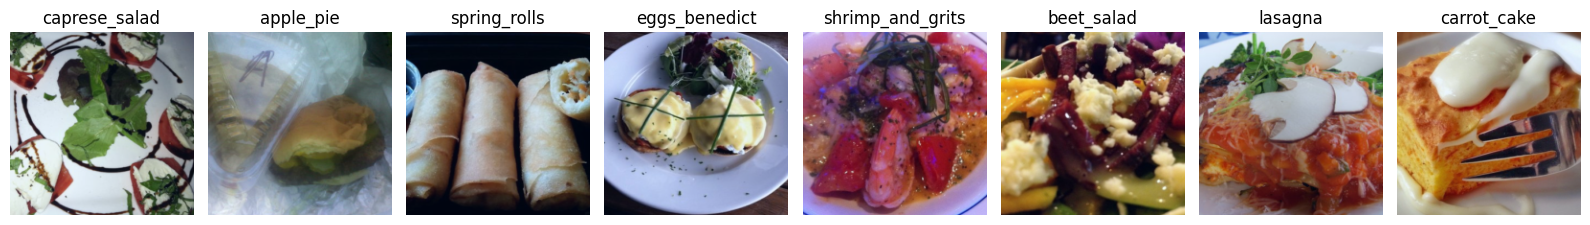

In [ ]:
import matplotlib.pyplot as plt
import random

def show_random_samples(dataset, class_names, n=8):
    idxs = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(16,4))

    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        img = img.permute(1,2,0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())

        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("appendix_random_samples.pdf")
    plt.show()

# Run
show_random_samples(val_dataset, filtered_classes, n=8)


In [ ]:
import torch
import numpy as np
from collections import defaultdict

def compute_per_class_accuracy(model, loader, num_classes):
    model.eval()
    correct = torch.zeros(num_classes)
    total = torch.zeros(num_classes)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            for cls in range(num_classes):
                mask = (y == cls)
                correct[cls] += (preds[mask] == y[mask]).sum().item()
                total[cls] += mask.sum().item()

    per_class_acc = (correct / total).cpu().numpy()
    return per_class_acc

# ✅ RUN THIS
per_class_acc = compute_per_class_accuracy(
    model,
    val_loader,
    num_classes=len(filtered_classes)
)

print("Computed per-class accuracy for", len(per_class_acc), "classes.")


Computed per-class accuracy for 101 classes.


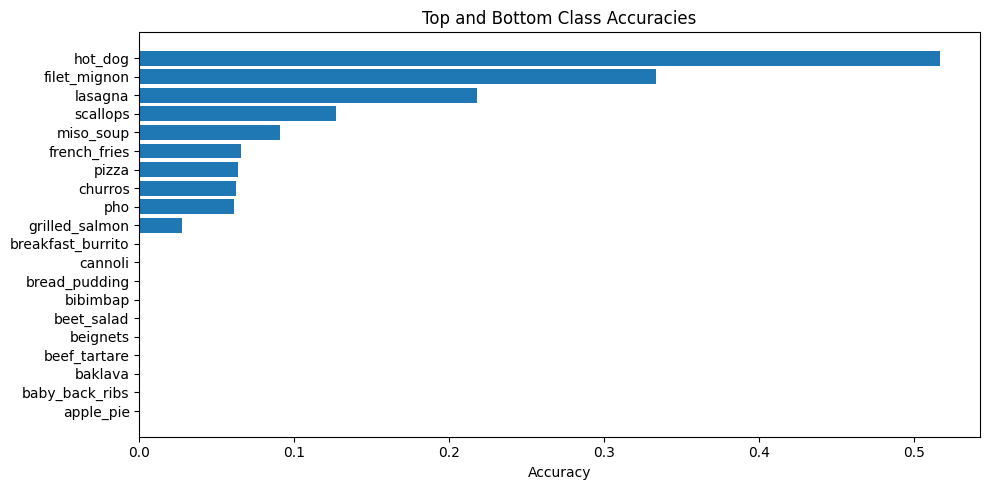

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_accuracy(per_class_acc, class_names, k=10):
    acc = np.array(per_class_acc)
    idx_sorted = np.argsort(acc)

    worst = idx_sorted[:k]
    best = idx_sorted[-k:]

    labels = [class_names[i] for i in list(worst) + list(best)]
    values = acc[list(worst) + list(best)]

    plt.figure(figsize=(10,5))
    plt.barh(labels, values)
    plt.xlabel("Accuracy")
    plt.title("Top and Bottom Class Accuracies")
    plt.tight_layout()
    plt.savefig("appendix_class_accuracy.pdf")
    plt.savefig("appendix_class_accuracy.png", dpi=300)
    plt.show()

# ✅ RUN THIS
plot_class_accuracy(per_class_acc, filtered_classes)


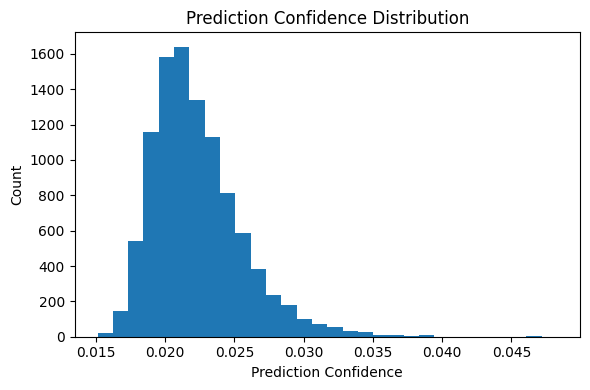

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_confidence_histogram(model, loader):
    model.eval()
    confidences = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            conf, _ = probs.max(dim=1)
            confidences.extend(conf.cpu().numpy())

    plt.figure(figsize=(6,4))
    plt.hist(confidences, bins=30)
    plt.xlabel("Prediction Confidence")
    plt.ylabel("Count")
    plt.title("Prediction Confidence Distribution")
    plt.tight_layout()
    plt.savefig("appendix_confidence_hist.pdf")
    plt.show()

# Run
plot_confidence_histogram(model, val_loader)


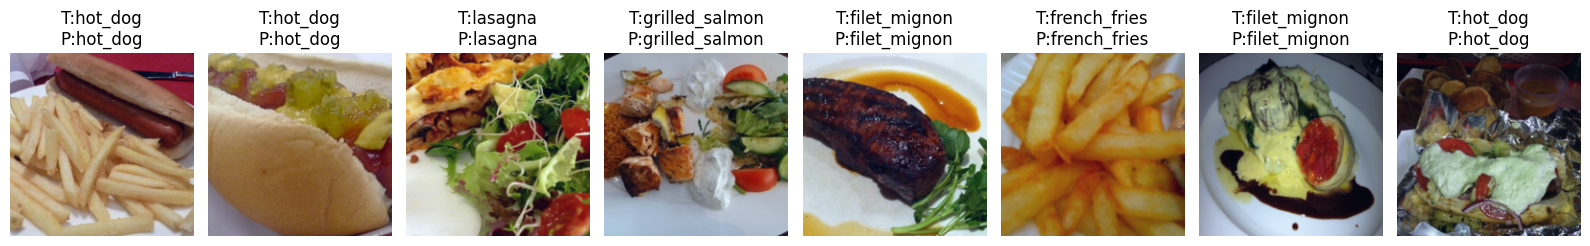

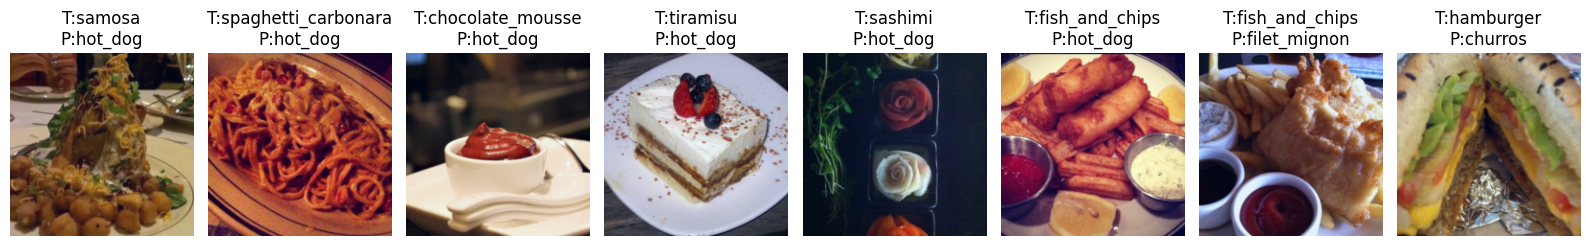

In [ ]:
def qualitative_grid(model, loader, class_names, correct=True, n=8):
    model.eval()
    images = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)

            mask = (preds == y) if correct else (preds != y)
            for i in torch.where(mask)[0]:
                images.append((x[i], y[i], preds[i]))
                if len(images) >= n:
                    break
            if len(images) >= n:
                break

    plt.figure(figsize=(16,4))
    for i, (img, y, p) in enumerate(images):
        img = img.permute(1,2,0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(f"T:{class_names[y]}\nP:{class_names[p]}")
        plt.axis("off")

    fname = "appendix_qual_correct.pdf" if correct else "appendix_qual_wrong.pdf"
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

# Run
qualitative_grid(model, val_loader, filtered_classes, correct=True)
qualitative_grid(model, val_loader, filtered_classes, correct=False)


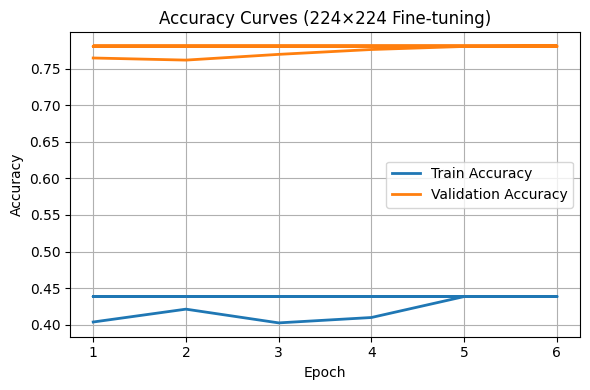

✅ Saved: acc_224.pdf and acc_224.png


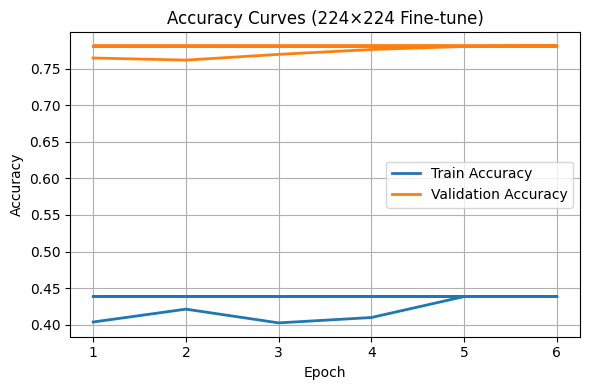

✅ Saved: acc_224.pdf and acc_224.png


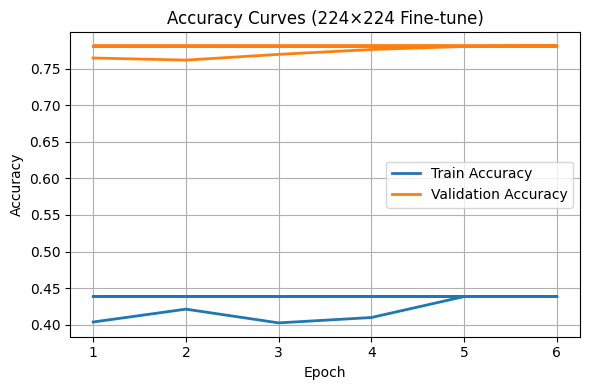

✅ Saved: acc_224.pdf and acc_224.png


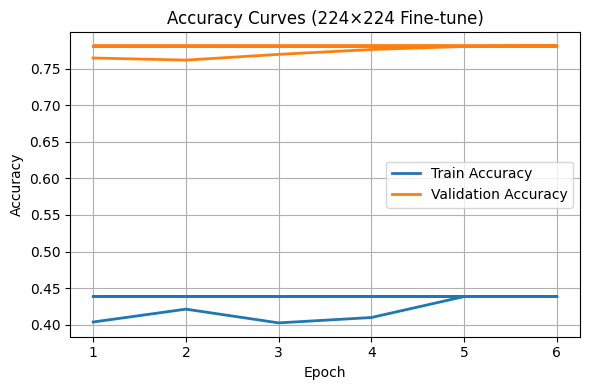

✅ Saved: acc_224.pdf and acc_224.png


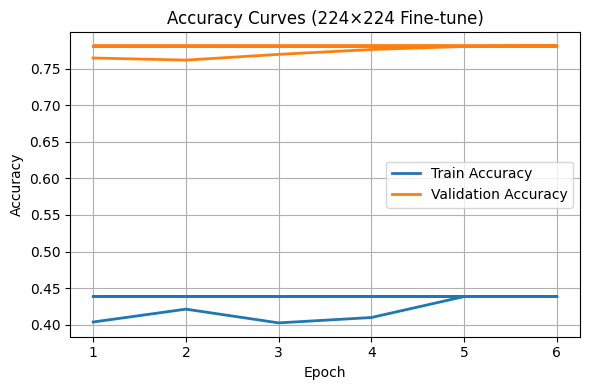

✅ Saved: acc_224.pdf and acc_224.png


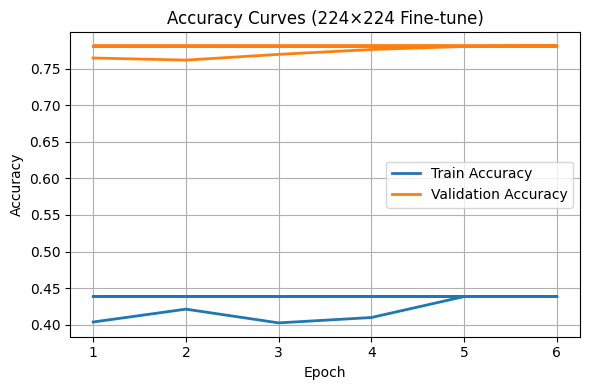

✅ Saved: acc_224.pdf and acc_224.png


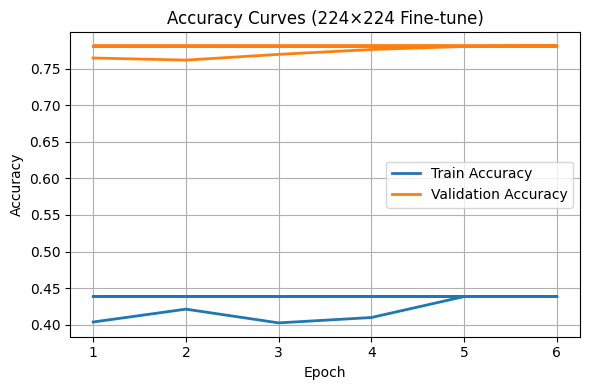

✅ Saved: acc_224.pdf and acc_224.png


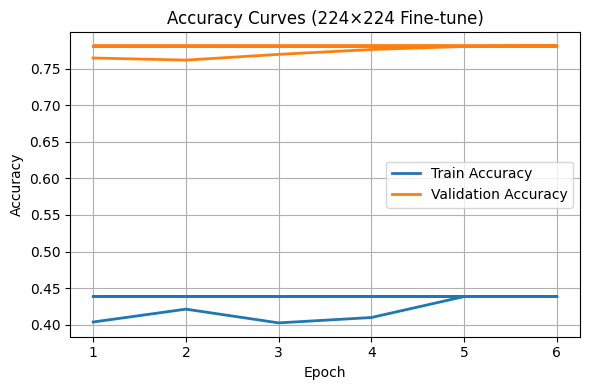

✅ Saved: acc_224.pdf and acc_224.png


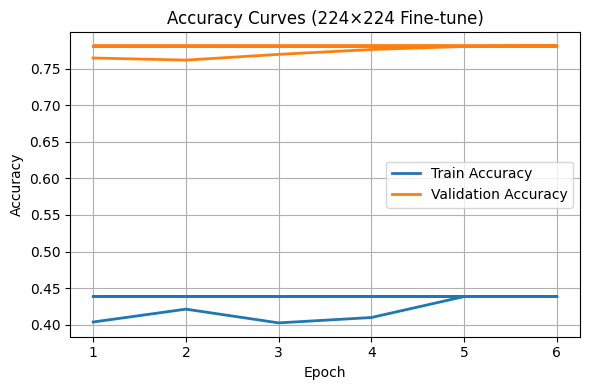

✅ Saved: acc_224.pdf and acc_224.png


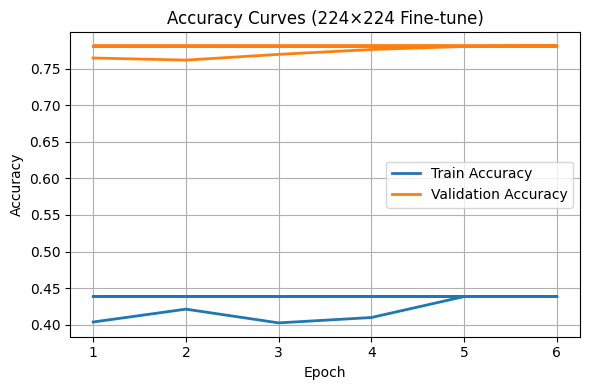

✅ Saved: acc_224.pdf and acc_224.png


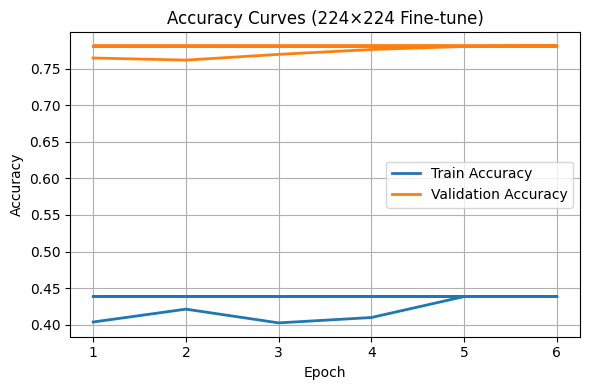

✅ Saved: acc_224.pdf and acc_224.png


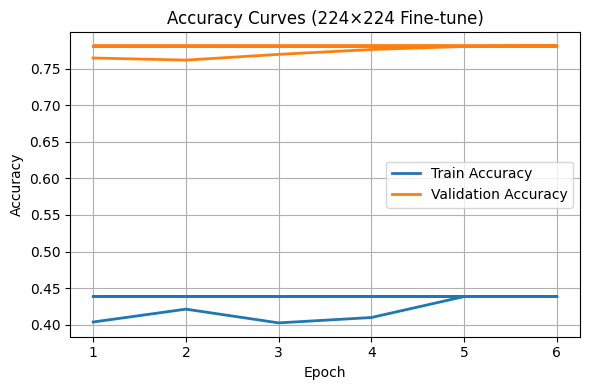

✅ Saved: acc_224.pdf and acc_224.png


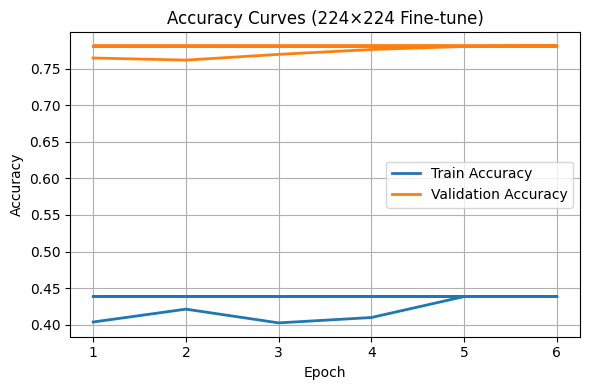

✅ Saved: acc_224.pdf and acc_224.png


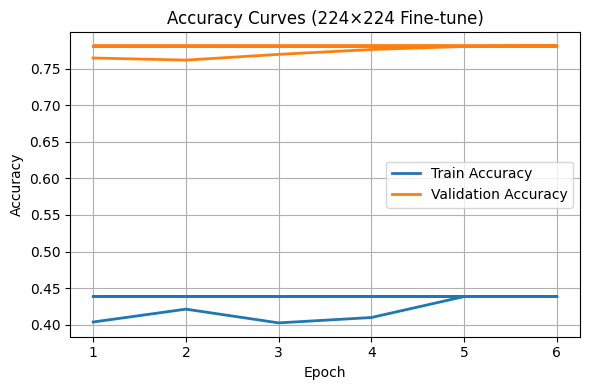

✅ Saved: acc_224.pdf and acc_224.png


KeyboardInterrupt: 

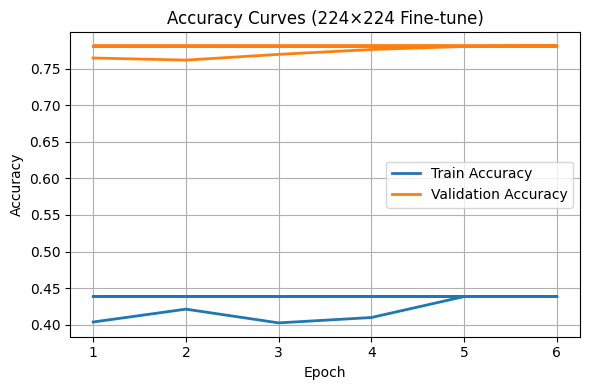

In [ ]:
# AFTER training finishes — plot ONCE
plot_acc_curve(
    epochs_224,
    train_acc_224,
    val_acc_224,
    "Accuracy Curves (224×224 Fine-tuning)",
    "acc_224"
)

plt.close()


In [ ]:
final_path = "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_FINAL_224.pt"

# after each epoch in the 224 loop:
if va_acc > best_val_acc:
    best_val_acc = va_acc
    torch.save({
        "model_state": model.state_dict(),
        "classes": filtered_classes,
        "num_classes": num_classes,
        "best_val_acc": best_val_acc,
        "img_size": 224,
        "batch_size": batch_size
    }, final_path)
    print("✅ Saved FINAL model:", final_path)


✅ Saved FINAL model: /content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_FINAL_224.pt


In [ ]:
import torch

def evaluate_top1(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

val_top1 = evaluate_top1(model, val_loader, device)
print(f"Validation Top-1 Accuracy: {val_top1:.4f} ({val_top1*100:.2f}%)")


Validation Top-1 Accuracy: 0.7742 (77.42%)


In [ ]:
def evaluate_topk(model, loader, device, k=5):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            topk = logits.topk(k, dim=1).indices  # [B, k]
            correct += (topk == y.unsqueeze(1)).any(dim=1).sum().item()
            total += y.size(0)
    return correct / total

val_top5 = evaluate_topk(model, val_loader, device, k=5)
print(f"Validation Top-5 Accuracy: {val_top5:.4f} ({val_top5*100:.2f}%)")


Validation Top-5 Accuracy: 0.9285 (92.85%)


Confusion matrix shape: (101, 101)

Top-10 Confusions (true -> predicted):
filet_mignon -> steak: 15
tuna_tartare -> beef_tartare: 12
steak -> filet_mignon: 12
apple_pie -> bread_pudding: 11
chocolate_cake -> chocolate_mousse: 11
ravioli -> gnocchi: 10
donuts -> beignets: 10
baby_back_ribs -> steak: 10
steak -> prime_rib: 9
ice_cream -> frozen_yogurt: 9


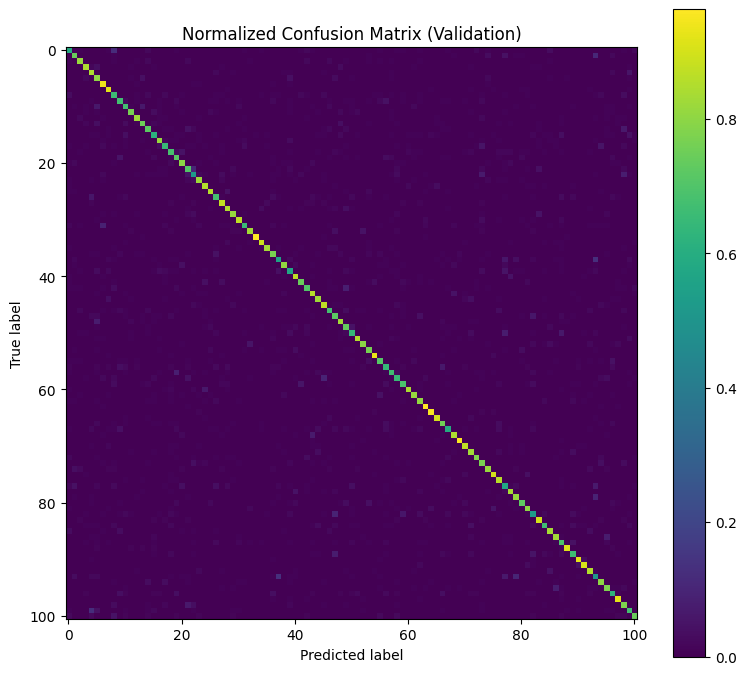

✅ Saved: confusion_matrix_norm.pdf and confusion_matrix_norm.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_preds_labels(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(y.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

preds, labels = get_preds_labels(model, val_loader, device)
cm = confusion_matrix(labels, preds)

print("Confusion matrix shape:", cm.shape)

# ----- Top-10 most frequent confusions (off-diagonal) -----
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

flat_idx = np.argsort(cm_off.ravel())[::-1]
top10 = []
for idx in flat_idx:
    i, j = divmod(idx, cm_off.shape[1])
    if cm_off[i, j] == 0:
        break
    top10.append((i, j, cm_off[i, j]))
    if len(top10) == 10:
        break

print("\nTop-10 Confusions (true -> predicted):")
for i, j, c in top10:
    true_name = filtered_classes[i] if "filtered_classes" in globals() else str(i)
    pred_name = filtered_classes[j] if "filtered_classes" in globals() else str(j)
    print(f"{true_name} -> {pred_name}: {c}")

# ----- Plot confusion matrix (normalized or raw) -----
# Normalize by true class counts for better readability:
cm_norm = cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(8, 7))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Normalized Confusion Matrix (Validation)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()

# Save for Overleaf
plt.savefig("confusion_matrix_norm.pdf")
plt.savefig("confusion_matrix_norm.png", dpi=300)
plt.show()

print("✅ Saved: confusion_matrix_norm.pdf and confusion_matrix_norm.png")


Correct examples found: 324
Wrong examples found: 76


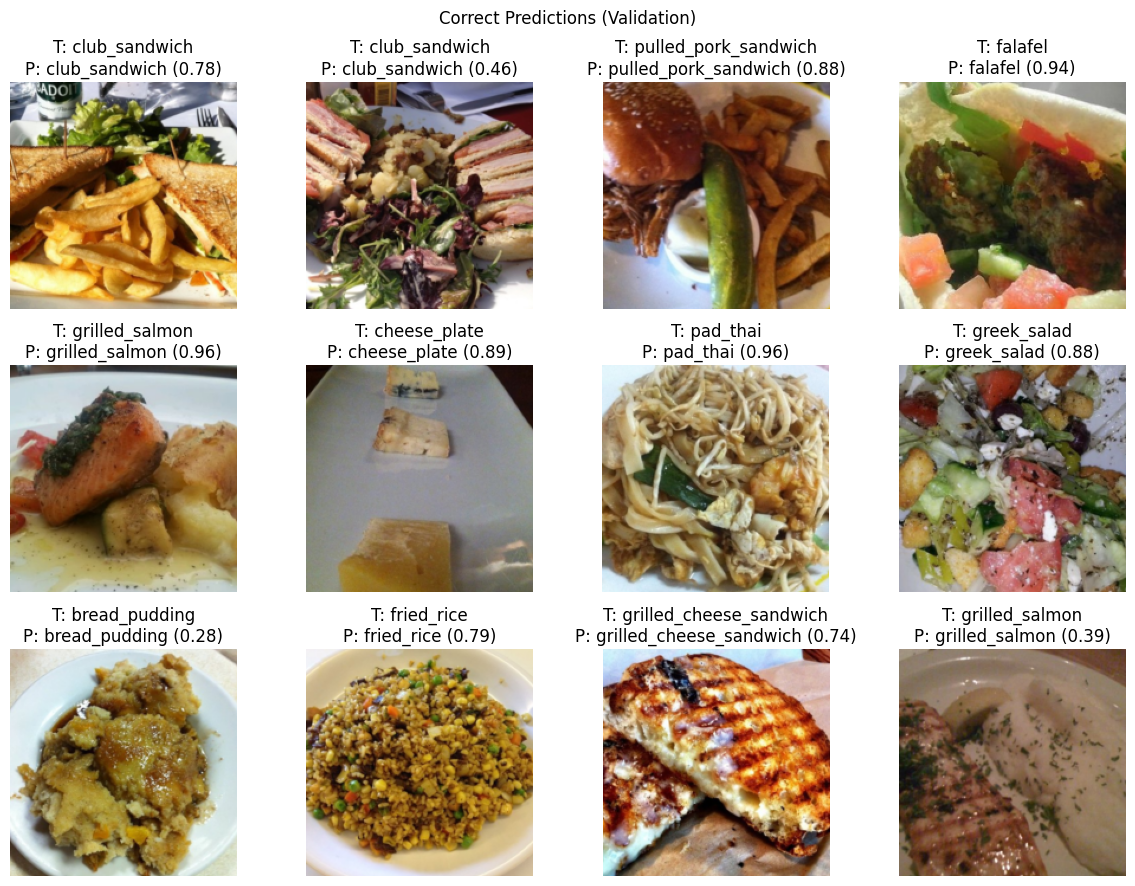

✅ Saved: qualitative_correct.pdf


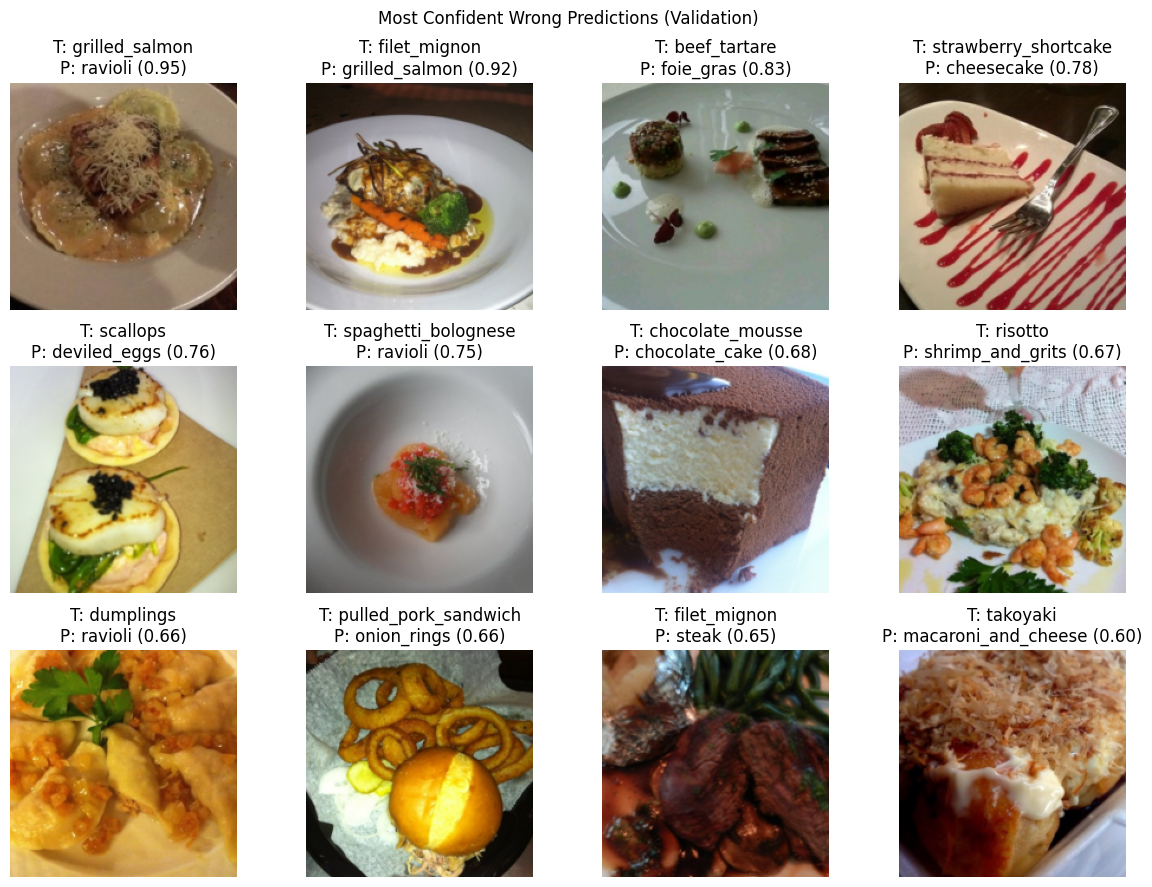

✅ Saved: qualitative_wrong.pdf


In [ ]:
import random
import torch
import matplotlib.pyplot as plt

def denormalize(img_tensor, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    """Convert normalized tensor CxHxW to displayable HxWxC numpy."""
    img = img_tensor.detach().cpu().clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).numpy()

def collect_examples(model, dataset, device, n_samples=200):
    """Collect predictions on random subset and return correct/wrong lists."""
    model.eval()
    idxs = random.sample(range(len(dataset)), min(n_samples, len(dataset)))

    correct_list = []
    wrong_list = []

    with torch.no_grad():
        for idx in idxs:
            x, y = dataset[idx]
            x_b = x.unsqueeze(0).to(device, non_blocking=True)
            logits = model(x_b)
            probs = torch.softmax(logits, dim=1).squeeze(0)
            pred = probs.argmax().item()
            conf = probs[pred].item()

            item = {
                "x": x, "y": y, "pred": pred, "conf": conf,
                "top5": torch.topk(probs, 5).indices.cpu().tolist()
            }

            if pred == y:
                correct_list.append(item)
            else:
                wrong_list.append(item)

    # Sort wrong by highest confidence mistakes (interesting for report)
    wrong_list.sort(key=lambda d: d["conf"], reverse=True)
    return correct_list, wrong_list

def plot_grid(examples, classes, title, filename_pdf, n_show=12):
    n_show = min(n_show, len(examples))
    cols = 4
    rows = int(np.ceil(n_show / cols))

    plt.figure(figsize=(12, 3*rows))
    for i in range(n_show):
        ex = examples[i]
        img = denormalize(ex["x"])
        true_name = classes[ex["y"]] if classes is not None else str(ex["y"])
        pred_name = classes[ex["pred"]] if classes is not None else str(ex["pred"])

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {true_name}\nP: {pred_name} ({ex['conf']:.2f})")

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(filename_pdf)
    plt.savefig(filename_pdf.replace(".pdf", ".png"), dpi=300)
    plt.show()
    print("✅ Saved:", filename_pdf)

# Collect examples
correct_list, wrong_list = collect_examples(model, val_dataset, device, n_samples=400)

print("Correct examples found:", len(correct_list))
print("Wrong examples found:", len(wrong_list))

# Plot grids
plot_grid(correct_list, filtered_classes, "Correct Predictions (Validation)", "qualitative_correct.pdf", n_show=12)
plot_grid(wrong_list, filtered_classes, "Most Confident Wrong Predictions (Validation)", "qualitative_wrong.pdf", n_show=12)


In [ ]:
import matplotlib.pyplot as plt

def plot_acc_curve(epochs, train_acc, val_acc, title, out_prefix):
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_acc, label="Train Accuracy", linewidth=2)
    plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{out_prefix}.pdf")
    plt.savefig(f"{out_prefix}.png", dpi=300)
    plt.show()
    print(f"✅ Saved: {out_prefix}.pdf and {out_prefix}.png")
  # Example usage (only if these lists exist):
   # plot_acc_curve(epochs_192, train_acc_192, val_acc_192, "Accuracy Curves (192×192)", "acc_192")
    plot_acc_curve(epochs_224, train_acc_224, val_acc_224, "Accuracy Curves (224×224 Fine-tune)", "acc_224")


In [ ]:
import torch
from collections import Counter
from tqdm import tqdm

model.eval()

confusions = Counter()

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Collecting confusions"):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        for true, pred in zip(y.cpu().tolist(), preds.cpu().tolist()):
            if true != pred:
                confusions[(true, pred)] += 1

# Top-10 confusion pairs
top_confusions = confusions.most_common(10)

print("\nTop-10 Confusion Pairs:")
for (t, p), c in top_confusions:
    print(f"{filtered_classes[t]} → {filtered_classes[p]} : {c}")

# -------- LaTeX table ----------
print("\nLaTeX table:")
print(r"\begin{table}[t]")
print(r"\centering")
print(r"\begin{tabular}{l l r}")
print(r"\hline")
print(r"True Class & Predicted Class & Count \\")
print(r"\hline")

for (t, p), c in top_confusions:
    print(f"{filtered_classes[t].replace('_',' ')} & "
          f"{filtered_classes[p].replace('_',' ')} & {c} \\\\")

print(r"\hline")
print(r"\end{tabular}")
print(r"\caption{Top-10 most frequent confusion pairs on the Food-101 validation set.}")
print(r"\label{tab:confusions}")
print(r"\end{table}")



Top-10 Confusion Pairs:
filet_mignon → steak : 15
steak → filet_mignon : 12
tuna_tartare → beef_tartare : 12
chocolate_cake → chocolate_mousse : 11
apple_pie → bread_pudding : 11
ravioli → gnocchi : 10
donuts → beignets : 10
baby_back_ribs → steak : 10
prime_rib → steak : 9
ice_cream → frozen_yogurt : 9

LaTeX table:
\begin{table}[t]
\centering
\begin{tabular}{l l r}
\hline
True Class & Predicted Class & Count \\
\hline
filet mignon & steak & 15 \\
steak & filet mignon & 12 \\
tuna tartare & beef tartare & 12 \\
chocolate cake & chocolate mousse & 11 \\
apple pie & bread pudding & 11 \\
ravioli & gnocchi & 10 \\
donuts & beignets & 10 \\
baby back ribs & steak & 10 \\
prime rib & steak & 9 \\
ice cream & frozen yogurt & 9 \\
\hline
\end{tabular}
\caption{Top-10 most frequent confusion pairs on the Food-101 validation set.}
\label{tab:confusions}
\end{table}


In [ ]:
import numpy as np

model.eval()

correct = Counter()
total = Counter()

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Per-class accuracy"):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        for true, pred in zip(y.cpu().tolist(), preds.cpu().tolist()):
            total[true] += 1
            if true == pred:
                correct[true] += 1

# Compute accuracy per class
per_class_acc = {
    cls: correct[i] / total[i]
    for i, cls in enumerate(filtered_classes)
}

# Sort
sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1], reverse=True)

print("\nTop-5 best classes:")
for cls, acc in sorted_acc[:5]:
    print(f"{cls}: {acc:.3f}")

print("\nTop-5 worst classes:")
for cls, acc in sorted_acc[-5:]:
    print(f"{cls}: {acc:.3f}")

Per-class accuracy: 100%|██████████| 79/79 [00:13<00:00,  5.99it/s]


Top-5 best classes:
macarons: 0.963
edamame: 0.960
oysters: 0.958
miso_soup: 0.955
beignets: 0.938

Top-5 worst classes:
foie_gras: 0.570
filet_mignon: 0.556
chocolate_mousse: 0.529
ravioli: 0.529
steak: 0.516


In [ ]:
final_path = "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_FINAL_224.pt"

ckpt = torch.load(final_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()


NameError: name 'model' is not defined

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print("Final validation accuracy:", correct / total)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", square=True, cbar=False)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
best_val_acc_224 = 0.0
final_path = "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_FINAL_224.pt"

for epoch in range(1, 7):  # your 224 fine-tune epochs
    tr_loss, tr_acc = run_epoch_amp(model, train_loader_224, train=True)
    va_loss, va_acc = run_epoch_amp(model, val_loader_224, train=False)

    print(f"[224] Epoch {epoch}/6 | train acc={tr_acc:.4f} | val acc={va_acc:.4f}")

    if va_acc > best_val_acc_224:
        best_val_acc_224 = va_acc

        torch.save({
            "model_state": model.state_dict(),
            "classes": filtered_classes,
            "num_classes": num_classes,
            "best_val_acc": best_val_acc_224,
            "img_size": 224,
        }, final_path)

        print("✅ Saved FINAL 224 model:", final_path)

print("🎯 Final 224 best validation accuracy:", best_val_acc_224)


NameError: name 'train_loader_224' is not defined

In [ ]:
IMG_SIZE_224 = 224

train_transform_224 = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE_224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform_224 = transforms.Compose([
    transforms.Resize(int(IMG_SIZE_224 / 0.875)),  # ~256
    transforms.CenterCrop(IMG_SIZE_224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


In [ ]:
train_dataset_224 = Food101Filtered(
    train_samples,
    orig_idx_to_class,
    class_to_idx,
    loader,
    transform=train_transform_224
)

val_dataset_224 = Food101Filtered(
    val_samples,
    orig_idx_to_class,
    class_to_idx,
    loader,
    transform=val_transform_224
)


In [ ]:
batch_size_224 = 96  # safer than 128 for 224

train_loader_224 = DataLoader(
    train_dataset_224,
    batch_size=batch_size_224,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0),
    drop_last=True
)

val_loader_224 = DataLoader(
    val_dataset_224,
    batch_size=batch_size_224,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0)
)


In [ ]:
best_val_acc_224 = 0.0

for epoch in range(1, 7):
    tr_loss, tr_acc = run_epoch_amp(model, train_loader_224, train=True)
    va_loss, va_acc = run_epoch_amp(model, val_loader_224, train=False)

    print(f"[224] Epoch {epoch}/6 | train acc={tr_acc:.4f} | val acc={va_acc:.4f}")

    if va_acc > best_val_acc_224:
        best_val_acc_224 = va_acc
        torch.save({
            "model_state": model.state_dict(),
            "classes": filtered_classes,
            "num_classes": num_classes,
            "best_val_acc": best_val_acc_224,
            "img_size": 224
        }, "/content/drive/MyDrive/DS_FINAL_PROJECT/resnet18_food101_FINAL_224.pt")
        print("✅ Saved best 224 model")


[224] Epoch 1/6 | train acc=0.4440 | val acc=0.7825
✅ Saved best 224 model


[224] Epoch 2/6 | train acc=0.4613 | val acc=0.7782


[224] Epoch 3/6 | train acc=0.4684 | val acc=0.7845
✅ Saved best 224 model


[224] Epoch 4/6 | train acc=0.4611 | val acc=0.7825


[224] Epoch 5/6 | train acc=0.4517 | val acc=0.7850
✅ Saved best 224 model


[224] Epoch 6/6 | train acc=0.4497 | val acc=0.7821
